In [1]:
import os
import cv2
import json
import torch
import imutils
import matplotlib
import numpy as np
import pandas as pd 
from PIL import Image
from deuces.Card import Card
from matplotlib import pyplot as plt
from deuces.Evaluator import Evaluator
plt.rcParams["figure.figsize"] = (8,8);

%matplotlib inline

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [3]:
def preprocess(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2 )
    thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1)
    blur_thresh = cv2.GaussianBlur(thresh,(5,5),5)
    return blur_thresh

In [82]:
diff_arr = []

In [90]:
def detect_cards(im, num = None):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
    #plt.imshow(blur, cmap = 'gray')
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)#[:numcards] 
    
#     for contour in contours:
#         cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
#     plt.figure()
#     plt.imshow(thresh)
    prev_list = []
    for i, elem in enumerate(contours):
        ar = cv2.contourArea(elem)
        if i == 0:
            pass
        else:
            prev_list.append( abs((ar - prev)/(prev+0.01)))
        prev = ar
        if i == 20:
            break
    for i, elem in enumerate(prev_list):
        if elem > 0.25:
            numcards = i+1
            break
    #print(prev_list)
    if num != None:
        numcards = num   
    #print(str(numcards) + " cards detected")
    r_all = []
    for i in range(numcards):
        card = contours[i]
        peri = cv2.arcLength(card,True)
        approx = cv2.approxPolyDP(card,0.02*peri,True)
        rect = cv2.minAreaRect(contours[i])
        r = cv2.boxPoints(rect)
        r_all.append(r)
    r_sort = []
    for r in r_all:
        approx = np.array(r, dtype = np.float32)
        i = approx
        x_s = sorted(i, key=lambda x: x[1])
        y_s = sorted(i, key=lambda x: x[0])
        x_s = [list(i) for i in x_s]
        y_s = [list(i) for i in y_s]
        ll = intersection(x_s[:2], y_s[:2])
        lu = intersection(x_s[:2], y_s[2:])
        rl = intersection(x_s[2:], y_s[:2])
        ru = intersection(x_s[2:], y_s[2:])
        ordered = [ll[0], lu[0], rl[0], ru[0]]
        ordered = np.array(ordered)
        r_sort.append(ordered)
    detected = []
    for locs in r_sort:
        h = np.array([[0,0],[199, 0], [0,299],[199,299]],np.float32)
        transform = cv2.getPerspectiveTransform(locs,h)
        warp = cv2.warpPerspective(im,transform,(200,300))
        corr = []
        names = []
        for num, i in enumerate(os.listdir(DIR_TEMP)):
            if i[0] == ".":
                continue
            template = cv2.imread(DIR_TEMP + "/" + i)
            diff = cv2.absdiff(preprocess(warp),preprocess(template))  
            diff = cv2.GaussianBlur(diff,(5,5),5)    
            flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
            #plt.imshow(diff)
            diff_arr.append([i[:2], diff]) 
            #axs[num, 0].imshow(x, y)
            corr.append((np.sum(diff), i))
        warp = cv2.rotate(warp, cv2.ROTATE_180)
        for i in os.listdir(DIR_TEMP):
            if i[0] == ".":
                continue
            template = cv2.imread(DIR_TEMP + "/" + i)
            diff = cv2.absdiff(preprocess(warp),preprocess(template))  
            diff = cv2.GaussianBlur(diff,(5,5),5)    
            flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY) 
            corr.append((np.sum(diff), i))
        warp = cv2.rotate(warp, cv2.ROTATE_180)
        ans = sorted(corr,key = lambda x: x[0])
        detected.append(ans[0][1][:-4])
        print(ans[0][1][:-4])
        
    arr_sort = []
    for i in range(len(detected)):
        arr_sort.append((detected[i], r_sort[i]))
        
    arr_sort = sorted(arr_sort, key = lambda x: x[1][0][1])
        
    detected = [i[0] for i in arr_sort]
    r_sort = [i[1] for i in arr_sort]
    #print(detected, r_sort)
    return detected, r_sort

In [91]:
DIR_TEMP = "templates"

In [92]:
im = cv2.imread("test/6_2.jpg")

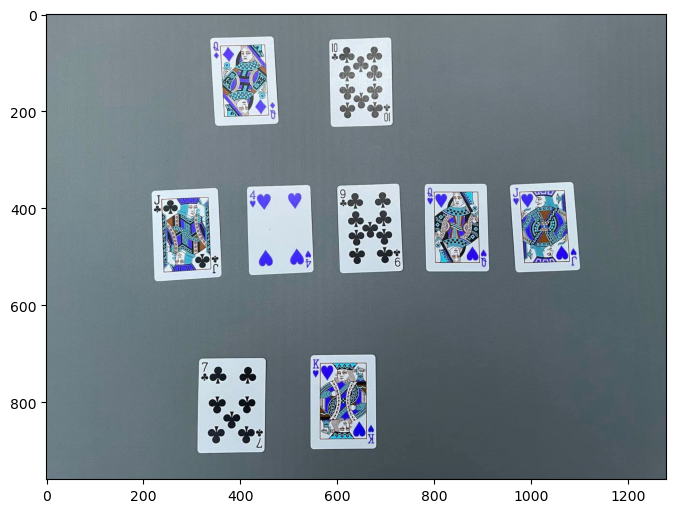

In [97]:
plt.imshow(im)

In [93]:
detected, r_sort = detect_cards(im)

7c
Kh
Jc
Jh
4h
Qd
Qh
9c
Tc


In [94]:
len(diff_arr)

954

['Qh', array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255, 255]], dtype=uint8)]
['Qh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
['Qh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
['Qh', array([[  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0

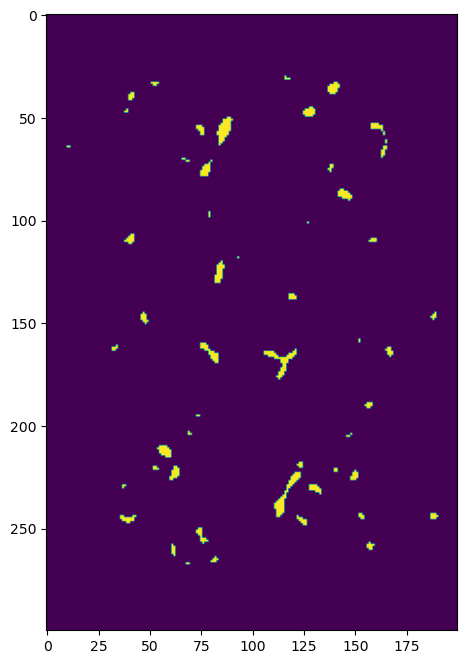

In [104]:
for i, elem in enumerate(diff_arr):
    if elem[0] == 'Tc':
        plt.imshow(diff_arr[i+1][1])
        print(diff_arr[i+1])

In [8]:
SAVE_DIR = "outputs"

In [9]:
# Calculating the rank

In [10]:
# try:
#     board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5]),Card.new(detected[6])]
# except:
#     try:
#         board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5])]
#     except:
#         board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4])]

# pl1_hand = [Card.new(detected[0]),Card.new(detected[1])]
# pl2_hand = [Card.new(detected[len(detected)-1]),Card.new(detected[len(detected)-2])]

# eval = Evaluator()
# score_pl1 = eval.evaluate(board, pl1_hand)
# score_pl2 = eval.evaluate(board, pl2_hand)

# print('First player rank: ',score_pl1)
# print('Second player rank: ',score_pl2)

Plot image:

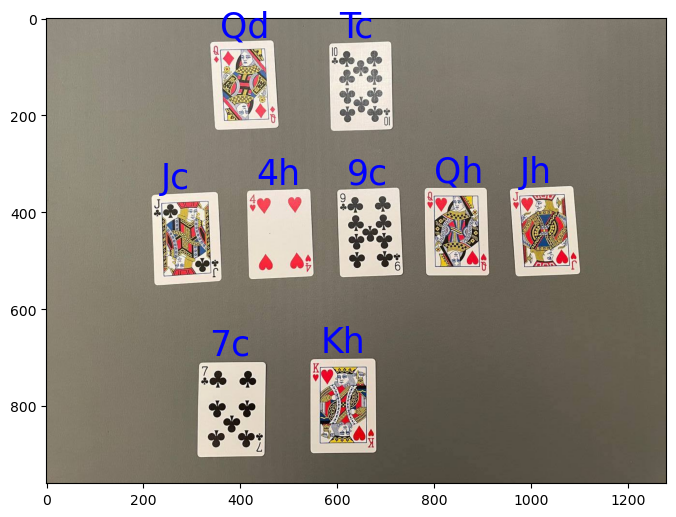

In [11]:
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

for i, elem in enumerate(r_sort):
    elem = elem[0]
    plt.text(elem[0] + 20, elem[1] - 15, detected[i], fontsize = 25, color = 'b')
#     if score_pl1 < score_pl2:
#         plt.text(100,100,round(score_pl2/ score_pl1, 2), fontsize = 25, color = 'b')
#         plt.text(100,800,1, fontsize = 25, color = 'b')
#     else:
#         plt.text(100,100, 1, fontsize = 25, color = 'b')
#         plt.text(100,800,score_pl1 / score_pl2, fontsize = 25, color = 'b')

    

In [12]:
def save_img(PIC_DIR, SAVE_DIR):
    ff = False
    plt.ioff();
    fig = plt.figure();
    plt.figure().clear();
    plt.close();
    plt.cla();
    plt.clf();
    im = cv2.imread(PIC_DIR)
    #print(im)
    detected, r_sort = detect_cards(im)
    #print(detected)
    
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #print(im_rgb)
    plt.imshow(im_rgb)
    
    try:
        board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5]),Card.new(detected[6])]
    except:
        try:
            board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5])]
        except:
            try:
                board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4])]
            except:
                ff = True
            
    if ff != True:
        pl1_hand = [Card.new(detected[0]),Card.new(detected[1])]
        pl2_hand = [Card.new(detected[len(detected)-1]),Card.new(detected[len(detected)-2])]

        eval = Evaluator()
        score_pl1 = eval.evaluate(board, pl1_hand)
        score_pl2 = eval.evaluate(board, pl2_hand)
    #plt.imshow(im_rgb);

    for i, elem in enumerate(r_sort):
        elem = elem[0]
        plt.text(elem[0] + 20, elem[1] - 15, detected[i], fontsize = 25, color = 'b');
        if not ff and score_pl1 < score_pl2:
            plt.text(100,100,round(score_pl2/ score_pl1, 2), fontsize = 25, color = 'r');
            plt.text(100,800,1, fontsize = 25, color = 'r');
        elif not ff:
            plt.text(100,100, 1, fontsize = 25, color = 'r');
            plt.text(100,800,score_pl1 / score_pl2, fontsize = 25, color = 'r');
        else:
            continue
            
    len_dir = len(os.listdir(SAVE_DIR))
    #print(SAVE_DIR + "/" + str(len_dir) +".png")
    plt.savefig(SAVE_DIR + "/" + str(len_dir) +".png")  
            
    plt.ion();

In [15]:
save_img("/Users/vadimartemov/Desktop/Poker_recogintion/test/6_1.jpg", SAVE_DIR)